# Import Library

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from keras import optimizers
from keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
import os
print(os.listdir("../input"))

Using TensorFlow backend.


['test1.zip', 'train.zip', 'sampleSubmission.csv']


# Unpackage zip file to train and test folders each
참고 링크: <https://www.kaggle.com/shaft49/cats-vs-dogs>

In [2]:
def make_directory(dir_path):
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

In [3]:
import zipfile


DATASET_PATH = '../output/dogs-vs-cats'

make_directory(DATASET_PATH)

# extract train data
with zipfile.ZipFile('../input/train.zip', 'r') as zip_ref:
    zip_ref.extractall(DATASET_PATH)

# extract test data
with zipfile.ZipFile('../input/test1.zip', 'r') as zip_ref:
    zip_ref.extractall(DATASET_PATH)

In [4]:
TRAIN_DATA_PATH = os.path.sep.join([DATASET_PATH, 'train'])
TEST_DATA_PATH = os.path.sep.join([DATASET_PATH, 'test1'])

train_files = os.listdir(TRAIN_DATA_PATH)
test_files = os.listdir(TEST_DATA_PATH)

# 25000 train images, 12500 test images
print(len(train_files), len(test_files))

25000 12500


# Train data preparation

**train_files**는 학습 이미지들의 파일명을 모아놓은 리스트 데이터이다. 최종적으로는 Cats vs Dogs 중 하나로 분류를 해야 하는 모델을 구축해야 하기 때문에 파일명에 **dogs**가 들어가면 1로, **cats**가 들어가면 0으로 class를 부여한다. 

In [5]:
# preview train files
train_files[:3]

['dog.890.jpg', 'dog.1178.jpg', 'dog.7845.jpg']

In [6]:
classes = []

for file in train_files:
    name = file.split('.')[0]
    if name == 'dog':
        classes.append(1)
    else:
        classes.append(0)

df = pd.DataFrame({'filename': train_files, 'class': classes})
df.head()

,filename,class
0,dog.890.jpg,1
1,dog.1178.jpg,1
2,dog.7845.jpg,1
3,dog.4632.jpg,1
4,cat.3660.jpg,0


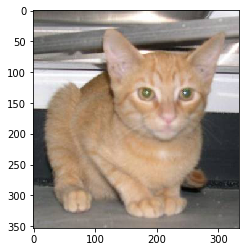

In [7]:
# preview sample image
sample = np.random.choice(train_files)
img = load_img(DATASET_PATH + '/train/' + sample)
plt.imshow(img)
plt.show()

# Generate train and validation data

In [8]:
img_size = 128
epochs = 30
batch_size = 32

In [9]:
train_df, validation_df = train_test_split(df, test_size = 0.2, random_state = 0)

train_df = train_df.reset_index(drop = True)
validation_df = validation_df.reset_index(drop = True)

train_size = train_df.shape[0]
validation_size = validation_df.shape[0]

print(f'Train size: {train_size}')
print(f'Validation size: {validation_size}')

Train size: 20000
Validation size: 5000


# Image data augmentation(데이터증강)
Overfitting을 방지하기 위해 Data Augmentation(데이터증강)을 한다. `ImageDataGenerator`을 이용하면 데이터 증강이 가능하다. 세부적인 option은 이 [문서](https://keras.io/api/preprocessing/image/)를 참고하면 된다.


**순서** 
1. `ImageDataGenerator`로 data augmentation generator을 생성한다.
2. `flow_from_directory`나 `flow_from_dataframe`을 사용하여 앞서 생성한 train & validation 데이터를 증강한다.

이 코드에서는 dataframe으로부터 이미지 데이터증강을 하기 때문에 `flow_from_dataframe`을 사용한다.

In [10]:
# 1. ImageDataGenerator
train_gen = ImageDataGenerator(
    rotation_range = 20,
    rescale=1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_gen = ImageDataGenerator(rescale=1./255)


# 2. Data Augmentation
train_gen_data = train_gen.flow_from_dataframe(
    train_df, 
    TRAIN_DATA_PATH, 
    x_col='filename',
    y_col='class',
    class_mode='binary',
    target_size=(img_size, img_size),
    batch_size=batch_size
)

val_gen_data = validation_gen.flow_from_dataframe(
    validation_df, 
    TRAIN_DATA_PATH, 
    x_col='filename',
    y_col='class',
    class_mode='binary',
    target_size=(img_size, img_size),
    batch_size=batch_size
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


Data Augmentation을 거친 이미지 데이터가 궁금하다면 방법은 다음과 같다.

Found 1 images belonging to 1 classes.


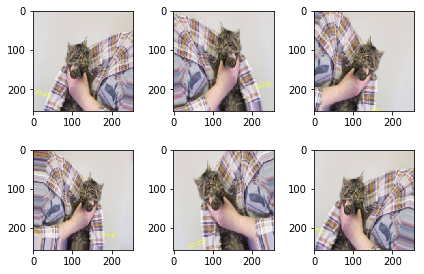

In [11]:
# preview data-augmented image
sample = train_df.sample(n=1).reset_index(drop = True) # 이미지 1개 랜덤 선택
sample_gen = train_gen.flow_from_dataframe(sample,
                                           TRAIN_DATA_PATH,
                                           x_col = 'filename',
                                           y_col = 'class',
                                           class_mode = 'binary')

for i in range(6): # batch에 있는 이미지 32개 중 이미지 6개 보기
    plt.subplot(2, 3, i+1)
    for x_batch, y_batch in sample_gen: # x_batch: img data with shape (1, 256, 256, 3), y_batch: 0 or 1(class)
        img = x_batch[0] # 첫번째 이미지 가져오기
        plt.imshow(img)
        break
plt.tight_layout()
plt.show()

# Build CNN Model
Sequential API를 이용해 구축한 모델

In [12]:
model = Sequential()

model.add(Conv2D(32,(3,3), activation='relu', input_shape=(img_size, img_size, 3), kernel_initializer = 'he_normal', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),activation='relu', kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1,activation = 'sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 62, 62, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0         
__________

In [13]:
es = EarlyStopping(monitor = 'val_acc', patience = 5, verbose = 1)
rp = ReduceLROnPlateau(monitor = 'val_acc', patience = 5, verbose = 1, factor = 0.5)

In [14]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

In [15]:
history = model.fit_generator(
    train_gen_data,
    epochs = epochs,
    validation_data = val_gen_data,
    steps_per_epoch = train_size//batch_size,
    validation_steps = validation_size//batch_size,
    callbacks = [es, rp])

Epoch 1/30
625/625 [==============================] - 144s 231ms/step - loss: 0.6699 - acc: 0.6544 - val_loss: 0.6231 - val_acc: 0.7053
Epoch 2/30
625/625 [==============================] - 138s 221ms/step - loss: 0.5136 - acc: 0.7486 - val_loss: 0.4583 - val_acc: 0.7905
Epoch 3/30
625/625 [==============================] - 136s 217ms/step - loss: 0.4536 - acc: 0.7873 - val_loss: 0.4727 - val_acc: 0.7961
Epoch 4/30
625/625 [==============================] - 135s 216ms/step - loss: 0.4136 - acc: 0.8132 - val_loss: 0.3407 - val_acc: 0.8519
Epoch 5/30
625/625 [==============================] - 137s 220ms/step - loss: 0.3849 - acc: 0.8285 - val_loss: 0.9518 - val_acc: 0.6190
Epoch 6/30
625/625 [==============================] - 134s 215ms/step - loss: 0.3592 - acc: 0.8429 - val_loss: 0.4014 - val_acc: 0.8347
Epoch 7/30
625/625 [==============================] - 134s 214ms/step - loss: 0.3427 - acc: 0.8502 - val_loss: 0.3041 - val_acc: 0.8756
Epoch 8/30
625/625 [============================

In [4]:
import seaborn as sns

epochs = history.history.epochs
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
sns.lineplot(range(1, 13), history.history['loss'], color = 'green', label = 'Train')
sns.scatterplot(range(1, 13), history.history['val_loss'], color = 'red', label = 'Validation')
plt.xticks(range(1, 13 ,)); plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.title('Loss vs Validation Loss', fontsize = 15)

plt.subplot(1, 2, 2)
sns.lineplot(range(1, 13, history.history['acc'], color = 'green', label = 'Train')
sns.scatterplot(range(1, 13, history.history['val_acc'], color = 'red', label = 'Validation')
plt.title('Accuracy vs Validation Accuracy', fontsize = 15)
plt.xticks(range(1, 13,2)); plt.xlabel('Epochs'); plt.ylabel('Accuracy')

plt.show()

SyntaxError: invalid syntax (<ipython-input-4-306f94426886>, line 14)

In [ ]:
loss, accuracy = model.evaluate_generator(val_gen_data, validation_size//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))